In [1]:
import json, requests
from requests.auth import HTTPBasicAuth
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

In [2]:
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
res_crashstation = requests.get(
    'http://localhost:9090/esq/indexname/crashstation'
)
res_location = requests.get(
    'http://localhost:9090/esq/indexname/location'
)
if res_crashstation.status_code == 200:
    crashstation_data = res_crashstation.json()['hits']
    location_data = res_location.json()['hits']
    
crashstations = pd.DataFrame([item['_source'] for item in crashstation_data])
locations = pd.DataFrame([item['_source'] for item in location_data])

In [3]:
crashstation_list = crashstations['stationname'].values.tolist()
crashstation_list

['bushy_park_(bushy_park_estates)',
 'dunalley_(stroud_point)',
 'friendly_beaches',
 'grove_(research_station)',
 'hobart_airport',
 'mount_read',
 'devonport_airport',
 'king_island_airport',
 'campania_(kincora)',
 'launceston_(ti_tree_bend)',
 'sheffield_school_farm',
 'ouse_fire_station',
 'tunnack_fire_station',
 'smithton_aerodrome',
 'hobart_(ellerslie_road)',
 'wynyard_airport',
 'scottsdale_(west_minstone_road)',
 'dennes_point',
 'flinders_island_airport',
 'low_head']

In [4]:
locations.head()

,Location,Latitude,Longitude
0,BUTLERS GORGE,-42.2753,146.2758
1,CAMPANIA (KINCORA),-42.6867,147.4258
2,CAPE GRIM,-40.6764,144.6922
3,CRESSY (BRUMBYS CREEK),-41.7114,147.082
4,KING ISLAND AIRPORT,-39.8804,143.8857


In [5]:
def get_crash_weather_df(start_year, end_year, locations):
    df = pd.DataFrame({'stationname': locations})
    dataframes = {} 
    end_year = end_year + 1
    
    for year_1 in range(start_year, end_year): 
        for index, row in df.iterrows():
            location = row['stationname']
            location_2 = location.replace('_', '%20').upper()
            url = f"http://localhost:9090/canalysis/year/{year_1}/crash/{location}/weather/{location_2}"      
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    data_string = response.json()
                    data = json.loads(data_string)
                    identifier = f"{year_1}-{location}"
                    if identifier not in dataframes:
                        dataframes[identifier] = pd.DataFrame()
                    temp_df = pd.json_normalize(data)
                    dataframes[identifier] = pd.concat([dataframes[identifier], temp_df], ignore_index=True)
                    print(f"Success：{identifier}")
                else:
                    print(f"Failed，status_code：{response.status_code}, URL：{url}")
            except requests.RequestException as e:
                print(f"Error，URL：{url}")
                print(e)

    for identifier, df in dataframes.items():
        print(f"Identifier: {identifier}, DataFrame shape: {df.shape}")

    for identifier in dataframes.keys():
    # identifier "year-location"
        year, location = identifier.split('-')
        location_no_parenthesis = location.replace('(', '').replace(')', '')
        variable_name = f"{location_no_parenthesis}_{year}_df"
        globals()[variable_name] = dataframes[identifier]
        print(f"Variable '{variable_name}' has been created")
    return dataframes

In [6]:
bushy_2016 = get_crash_weather_df(2016, 2016, ['bushy_park_(bushy_park_estates)'])

Success：2016-bushy_park_(bushy_park_estates)
Identifier: 2016-bushy_park_(bushy_park_estates), DataFrame shape: (12, 21)
Variable 'bushy_park_bushy_park_estates_2016_df' has been created


In [7]:
bushy_park_bushy_park_estates_2016_df.columns

Index(['location', 'crash_count', 'maxRain', 'avgRain', 'sumRain',
       'Zero_Rain_Percent', 'maxTemp', 'avgTemp', 'sumTemp', 'date.day',
       'date.day_of_year', 'date.dayofyear', 'date.daysinmonth',
       'date.freqstr', 'date.is_leap_year', 'date.month', 'date.ordinal',
       'date.qyear', 'date.start_time', 'date.week', 'date.weekofyear'],
      dtype='object')

In [8]:
def combine_date_columns(df):
    if 'date.qyear' in df.columns and 'date.month' in df.columns:
        df['date.qyear'] = df['date.qyear'].astype(str)
        df['date.month'] = df['date.month'].astype(str)
        df['date'] = df['date.qyear'] + '-' + df['date.month'].str.zfill(2)
    else:
        raise ValueError("DataFrame lack 'date.qyear' or 'date.month'column.")
    return df

for var_name, var_value in [(key, value) for key, value in globals().items() if isinstance(value, pd.DataFrame) and key.endswith('_df')]:
    try:
        globals()[var_name] = combine_date_columns(var_value)
        print(f"{var_name} has been updated")
    except ValueError as e:
        print(f"Processing {var_name} error: {e}")

bushy_park_bushy_park_estates_2016_df has been updated


In [9]:
bushy_park_bushy_park_estates_2016_df['date'].head()

0    2016-01
1    2016-02
2    2016-03
3    2016-04
4    2016-05
Name: date, dtype: object

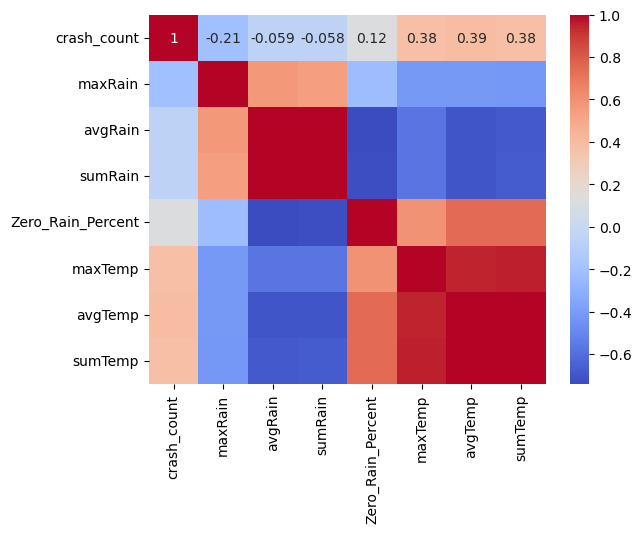

For 'crash_count' , most_positive_correlated_column: avgTemp (r = 0.39)
For 'crash_count' , most_negative_correlated_column: maxRain (r = -0.21)


In [10]:
bushy_park_bushy_park_estates_2016_df = bushy_park_bushy_park_estates_2016_df[['crash_count', 'maxRain', 'avgRain', 'sumRain', 'Zero_Rain_Percent', 'maxTemp', 'avgTemp', 'sumTemp', 'date']]

df = bushy_park_bushy_park_estates_2016_df.drop('date', axis=1) 
correlation_matrix = df.corr()
target_column = 'crash_count'
corrs = correlation_matrix[target_column].drop(target_column)

most_positive_correlated_column = corrs.idxmax()
most_negative_correlated_column = corrs.idxmin()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
print(f"For '{target_column}' , most_positive_correlated_column: {most_positive_correlated_column} (r = {corrs.max():.2f})")
print(f"For '{target_column}' , most_negative_correlated_column: {most_negative_correlated_column} (r = {corrs.min():.2f})")

In [11]:
bushy_park_bushy_park_estates_2016_df

,crash_count,maxRain,avgRain,sumRain,Zero_Rain_Percent,maxTemp,avgTemp,sumTemp,date
0,14,18.0,0.9,27.6,0.870968,36.1,25.3,784.9,2016-01
1,13,9.6,0.6,16.4,0.620690,32.1,24.3,705.6,2016-02
2,7,2.4,0.3,8.2,0.741935,31.3,23.3,723.8,2016-03
3,7,4.8,0.4,13.4,0.766667,26.1,20.6,616.7,2016-04
4,9,15.0,3.0,94.4,0.451613,21.8,14.3,443.5,2016-05
5,3,28.6,2.3,68.0,0.433333,18.4,12.3,370.2,2016-06
6,14,23.0,3.4,104.0,0.354839,17.1,12.9,399.0,2016-07
7,6,5.4,0.9,28.4,0.451613,19.6,13.6,420.2,2016-08
8,5,35.0,1.7,50.0,0.600000,22.8,16.9,508.0,2016-09
9,6,14.2,2.8,85.6,0.419355,24.7,14.7,454.3,2016-10


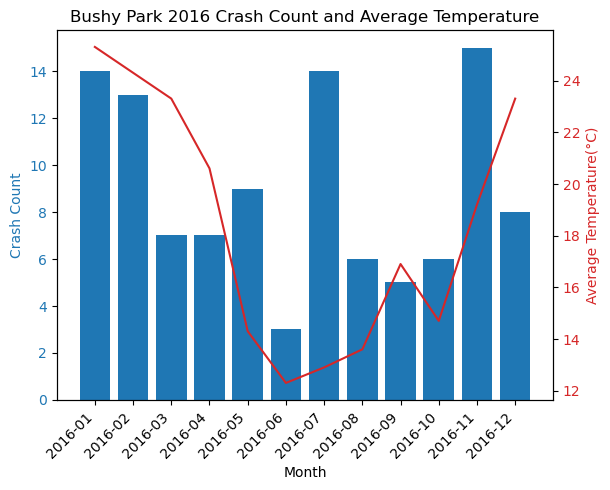

In [12]:
fig, ax1 = plt.subplots()

ax1.set_title('Bushy Park 2016 Crash Count and Average Temperature')
ax1.set_xlabel('Month')
ax1.set_ylabel('Crash Count', color='tab:blue')

color = 'tab:blue'
ax1.bar(bushy_park_bushy_park_estates_2016_df['date'], bushy_park_bushy_park_estates_2016_df['crash_count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()

ax2.set_ylabel('Average Temperature(°C)', color='tab:red') 
ax2.plot(bushy_park_bushy_park_estates_2016_df['date'], bushy_park_bushy_park_estates_2016_df['avgTemp'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

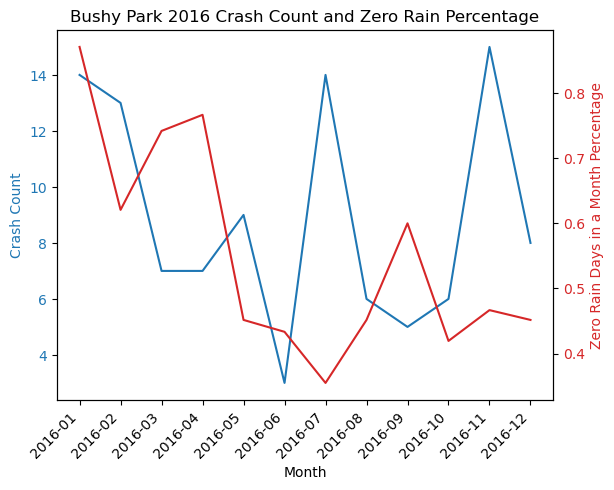

In [13]:
fig, ax1 = plt.subplots()

ax1.set_title('Bushy Park 2016 Crash Count and Zero Rain Percentage')
ax1.set_xlabel('Month')
ax1.set_ylabel('Crash Count', color='tab:blue')

color = 'tab:blue'
ax1.plot(bushy_park_bushy_park_estates_2016_df['date'], bushy_park_bushy_park_estates_2016_df['crash_count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()

ax2.set_ylabel('Zero Rain Days in a Month Percentage', color='tab:red') 
ax2.plot(bushy_park_bushy_park_estates_2016_df['date'], bushy_park_bushy_park_estates_2016_df['Zero_Rain_Percent'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

In [14]:
del bushy_park_bushy_park_estates_2016_df

In [15]:
crash_weather_dataframes = get_crash_weather_df(2012, 2018, crashstation_list)

Success：2012-bushy_park_(bushy_park_estates)
Success：2012-dunalley_(stroud_point)
Success：2012-friendly_beaches
Success：2012-grove_(research_station)
Success：2012-hobart_airport
Success：2012-mount_read
Success：2012-devonport_airport
Success：2012-king_island_airport
Success：2012-campania_(kincora)
Success：2012-launceston_(ti_tree_bend)
Success：2012-sheffield_school_farm
Success：2012-ouse_fire_station
Success：2012-tunnack_fire_station
Success：2012-smithton_aerodrome
Success：2012-hobart_(ellerslie_road)
Success：2012-wynyard_airport
Success：2012-scottsdale_(west_minstone_road)
Success：2012-dennes_point
Success：2012-flinders_island_airport
Success：2012-low_head
Success：2013-bushy_park_(bushy_park_estates)
Success：2013-dunalley_(stroud_point)
Success：2013-friendly_beaches
Success：2013-grove_(research_station)
Success：2013-hobart_airport
Success：2013-mount_read
Success：2013-devonport_airport
Success：2013-king_island_airport
Success：2013-campania_(kincora)
Success：2013-launceston_(ti_tree_bend

In [16]:
def process_df(df):
    if 'crash_count' not in df.columns:
        return None  
    aggregated_data = {'crash_count': df['crash_count'].sum()}
    for col in df.columns:
        if col != 'crash_count':
            aggregated_data[col] = df[col].iloc[0] 
    aggregated_df = pd.DataFrame([aggregated_data])
    return aggregated_df

all_dfs = [(key, value) for key, value in globals().items() if isinstance(value, pd.DataFrame) and key.endswith('_df')]

final_df = pd.DataFrame()

for var_name, df in all_dfs:
    processed_df = process_df(df)
    if processed_df is not None:  
        final_df = pd.concat([final_df, processed_df], ignore_index=True)

final_df['date.qyear'] = pd.to_numeric(final_df['date.qyear'], errors='coerce')
len(final_df)

140

In [17]:
data = [item['_source'] for item in location_data]

locations_coordinates = {}

for item in data:
    location_key = item['Location'].lower().replace(" ", "_")
    coordinates = (float(item['Latitude']), float(item['Longitude']))
    locations_coordinates[location_key] = coordinates

print(locations_coordinates)

{'butlers_gorge': (-42.2753, 146.2758), 'campania_(kincora)': (-42.6867, 147.4258), 'cape_grim': (-40.6764, 144.6922), 'cressy_(brumbys_creek)': (-41.7114, 147.082), 'king_island_airport': (-39.8804, 143.8857), 'liawenee': (-41.8997, 146.6694), 'maria_island_(point_lesueur)': (-42.6621, 148.0179), 'mount_read': (-41.8444, 145.5417), 'ouse_fire_station': (-42.4842, 146.7106), 'scottsdale_(west_minstone_road)': (-41.1708, 147.4883), 'smithton_aerodrome': (-40.8347, 145.0847), 'st_helens_aerodrome': (-41.3381, 148.2792), 'strahan_aerodrome': (-42.155, 145.2908), 'tunnack_fire_station': (-42.4543, 147.4612), 'wynyard_airport': (-40.9964, 145.7311), 'bushy_park_(bushy_park_estates)': (-42.7097, 146.8983), 'cape_bruny_(cape_bruny)': (-43.4886, 147.1444), 'devonport_airport': (-41.1701, 146.4289), 'fingal_(fleming_st)': (-41.643, 147.98), 'hartz_mountain_(keoghs_pimple)': (-43.2006, 146.7683), 'hobart_(ellerslie_road)': (-42.8897, 147.3278), 'hobart_airport': (-42.8333, 147.5119), 'kunanyi_(m

In [18]:
m = folium.Map(location=[-42.0, 147.0], zoom_start=7)

for year in sorted(final_df['date.qyear'].unique()):
    heat_data = []
    year_df = final_df[final_df['date.qyear'] == year]  
    for idx, row in year_df.iterrows():
        coords = locations_coordinates.get(row['location'])
        if coords:
            heat_data.append(coords + (row['crash_count'],))
    
    if heat_data:
        HeatMap(data=heat_data, name=f'Year {year}', show=False).add_to(m)

folium.LayerControl().add_to(m)

m.save('tasmania_crashes_heatmap_by_year.html')